# Libraries

In [1]:
# -- Standard Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# -- Model --
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.utils.data import DataLoader, Dataset
# -- Error Metrics --
from sklearn.metrics import mean_squared_error, r2_score
# -- Model Selection --
from sklearn.model_selection import train_test_split, cross_val_score

Fix description of data

## Data Description

In [2]:
# Give names to the features
index_names = ['engine', 'cycle']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_info = [ 
"(Fan inlet temperature) (◦R)",
"(LPC outlet temperature) (◦R)",
"(HPC outlet temperature) (◦R)",
"(LPT outlet temperature) (◦R)",
"(Fan inlet Pressure) (psia)",
"(bypass-duct pressure) (psia)",
"(HPC outlet pressure) (psia)",
"(Physical fan speed) (rpm)",
"(Physical core speed) (rpm)",
"(Engine pressure ratio(P50/P2)",
"(HPC outlet Static pressure) (psia)",
"(Ratio of fuel flow to Ps30) (pps/psia)",
"(Corrected fan speed) (rpm)",
"(Corrected core speed) (rpm)",
"(Bypass Ratio) ",
"(Burner fuel-air ratio)",
"(Bleed Enthalpy)",
"(Required fan speed)",
"(Required fan conversion speed)",
"(High-pressure turbines Cool air flow)",
"(Low-pressure turbines Cool air flow)" 
]

def name_sensor_data(sensor_info: list):
    '''Helper to describe sensor data and get column names'''
    sensor_dict = {}
    for i, sensor in enumerate(sensor_info):
        sensor_dict['s_'+ str(i + 1)] = sensor

    sensor_names = list(sensor_dict.keys())
    col_names = index_names + setting_names + sensor_names
    return sensor_dict, col_names

sensor_description, col_names = name_sensor_data(sensor_info)

In [3]:
from pathlib import Path

data_path = Path("..") / "data" / "CMaps"


df_train = pd.read_csv(data_path / "train_FD001.txt",
                       sep=r'\s+', header=None, index_col=False, names=col_names)
df_test = pd.read_csv( data_path / "test_FD001.txt",
                      sep=r'\s+', header=None, index_col=False, names=col_names)
y_valid = pd.read_csv(data_path /"RUL_FD001.txt",
                     sep=r'\s+', header=None, names=['RUL'])
print(f"Test Shape: {df_test.shape}\nTrain Shape:{df_train.shape}\nRUL Labels: {y_valid.shape}")
print(f"Percentage of the test-set: {len(df_test)/(len(df_train)+len(df_test))*100:.3f}%")

Test Shape: (13096, 26)
Train Shape:(20631, 26)
RUL Labels: (100, 1)
Percentage of the test-set: 38.829%


### Detect nulls and add RUL

In [4]:
def detect_null(dfs: list):
    results = []
    for i, df in enumerate(dfs):
        null_mask = df.isnull().any(axis=1)
        null_row_idx = np.where(null_mask)[0]
        null_counts = df.isnull().sum(axis=1)
        results.append((i, null_row_idx, null_mask, null_counts))
        print(f"Dataframe {i}:")
        print(f"|   Total tows with nulls: {len(null_row_idx)}")
        print(f"|   Total null values {df.isnull().sum().sum()}")
        if len(null_row_idx) > 0:
            print(f"  Rows with nulls: {null_row_idx.tolist()[:10]}")  
            if len(null_row_idx) > 10:
                print(f"  ... and {len(null_row_idx) - 10} more")
        else:
            print(f"|-->No null values detected!\n")

    return results

null_report = detect_null([df_train, df_test, y_valid])

Dataframe 0:
|   Total tows with nulls: 0
|   Total null values 0
|-->No null values detected!

Dataframe 1:
|   Total tows with nulls: 0
|   Total null values 0
|-->No null values detected!

Dataframe 2:
|   Total tows with nulls: 0
|   Total null values 0
|-->No null values detected!



In [5]:
def add_RUL(
        df, 
        unit_col='engine', 
        cycle_col='cycle', 
        rul_col='RUL', 
        clip_max=None
    ):
    max_cycles = df.groupby(unit_col)[cycle_col].transform('max')
    df[rul_col] = max_cycles - df[cycle_col]
    if clip_max is not None:
        # 1. clipping helps the model to have a narrower prediction space, 
        # using clip(upper) we hope the model gets a high value but at the same time does not overstimate the RUL
        # i.e., a machine could fail if we expect it to fail at 200 but fails at 190 for some reason
        # so we are telling the model to expect less, like a quantile regression
        # https://www.kaggle.com/code/wassimderbel/nasa-predictive-maintenance-rul
        df[rul_col] = df[rul_col].clip(upper=clip_max) # 
    return df

df_train = add_RUL(df_train, clip_max=130)
df_train[['cycle','RUL']].head(5)

,cycle,RUL
0,1,130
1,2,130
2,3,130
3,4,130
4,5,130


In [6]:
df_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
engine,20631.0,51.506568,2.922763e+01,1.0000,26.0000,52.0000,77.0000,100.0000
cycle,20631.0,108.807862,6.888099e+01,1.0000,52.0000,104.0000,156.0000,362.0000
setting_1,20631.0,-0.000009,2.187313e-03,-0.0087,-0.0015,0.0000,0.0015,0.0087
setting_2,20631.0,0.000002,2.930621e-04,-0.0006,-0.0002,0.0000,0.0003,0.0006
setting_3,20631.0,100.000000,0.000000e+00,100.0000,100.0000,100.0000,100.0000,100.0000
s_1,20631.0,518.670000,6.537152e-11,518.6700,518.6700,518.6700,518.6700,518.6700
s_2,20631.0,642.680934,5.000533e-01,641.2100,642.3250,642.6400,643.0000,644.5300
s_3,20631.0,1590.523119,6.131150e+00,1571.0400,1586.2600,1590.1000,1594.3800,1616.9100
s_4,20631.0,1408.933782,9.000605e+00,1382.2500,1402.3600,1408.0400,1414.5550,1441.4900
s_5,20631.0,14.620000,3.394700e-12,14.6200,14.6200,14.6200,14.6200,14.6200


# Model Performance

In [7]:
from pprint import pp
def evaluate(
    y_true,
    y_pred,
    label: str = ''
):
    """Evaluation function"""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    pp({
        "label": label,
        "RMSE": rmse,
        "R2": r2
    })

def plot_performance(
        y_true: torch.Tensor, 
        y_pred: torch.Tensor,
        max_engines: int = None,
        figsize: tuple = ((25,10))
    ):
    '''Visualization of predicted vs actual RUL'''
    
    fig, ax = plt.subplots(figsize=figsize)

    y_true_full = np.array(y_true).flatten()
    y_pred_full = np.array(y_pred).flatten()

    if max_engines is not None:
        y_true = y_true_full[:max_engines].astype(float)
        y_pred = y_pred_full[:max_engines].astype(float)


    indices = np.arange(len(y_true))
    bar_width = 0.35

    ax.bar(
        x=indices - bar_width / 2, 
        height=y_true,
        width=bar_width,
        color='#2ecc71',
        alpha=0.8,
        label='[True] RUL'
    )
    ax.bar(
        x=indices + bar_width / 2,
        height=y_pred,
        width=bar_width,
        color='#e74c3c',
        alpha = 0.8,
        label='[Pred] RUL',
    )
    
    # Showtime
    for i, (true, pred) in enumerate(zip(y_true, y_pred)):
        ax.plot(
            [i - bar_width / 2, i + bar_width / 2],
            [true, pred],
            color='#34495e',
            ls=':',
            alpha=0.6
        )
        
    ax.set_title('RUL Prediction Performance', fontsize=20, pad=20)
    ax.set_xlabel('Engine Index', fontsize=16)
    ax.set_ylabel('RUL (cycles)', fontsize=16)
    ax.set_xticks(indices)
    ax.legend(framealpha=1,)
    ax.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()

## Clean data, no useless sensors and added rolling data

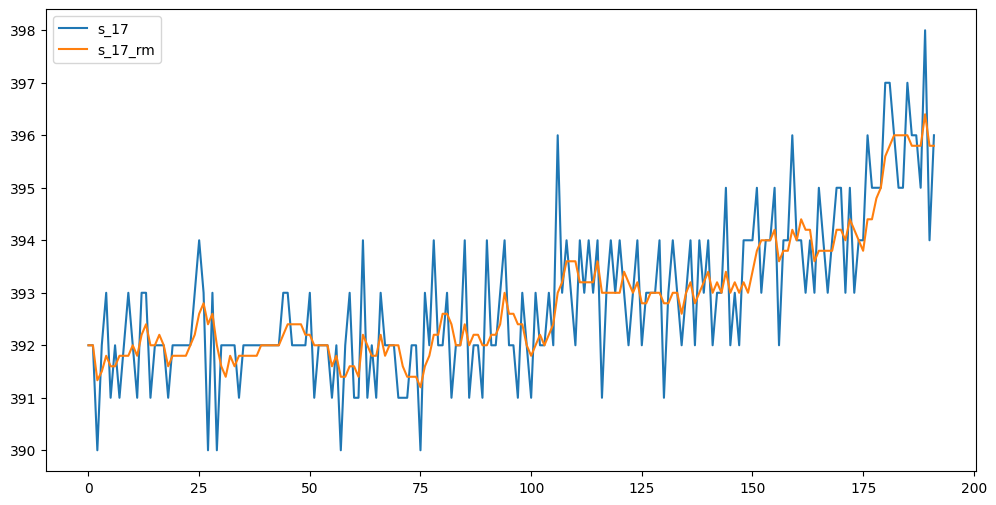

In [8]:
drop_cols = [
    "setting_1",
    "setting_2",
    "setting_3",
    "cycle",
    "s_1", "s_5", "s_6","s_10", "s_16", "s_18", "s_19"
]

df_clean = df_train.drop(columns=drop_cols)
feature_columns = [col for col in df_clean.columns]


def calculate_rolling_mean(df, window=5):
    '''Calculates rolling features'''
    df = df.copy()

    sensor_cols = [c for c in df.columns if c.startswith("s_")]

    if window > 1:
        for sensor in sensor_cols:
            df[f"{sensor}_rm"] = (
                df.groupby("engine")[sensor]
                .transform(lambda x: x.rolling(window, min_periods=1).mean())
            )
        return df   
    else:
        return df

df_rm = calculate_rolling_mean(df_clean)
sample_engine = df_rm[df_rm['engine'] == 1]
sample_engine[['s_17', 's_17_rm']].plot(figsize=(12,6));

In [9]:
df_rm.drop(['engine'], axis=1, inplace=True)
X_clean = df_rm.drop(["RUL"], axis=1)
y_clean = df_rm["RUL"]
feature_columns = list(X_clean.columns)
input_dim = len(feature_columns)
print(f"Input dim: {input_dim} \n Feature Columns: {feature_columns}")

Input dim: 28 
 Feature Columns: ['s_2', 's_3', 's_4', 's_7', 's_8', 's_9', 's_11', 's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21', 's_2_rm', 's_3_rm', 's_4_rm', 's_7_rm', 's_8_rm', 's_9_rm', 's_11_rm', 's_12_rm', 's_13_rm', 's_14_rm', 's_15_rm', 's_17_rm', 's_20_rm', 's_21_rm']


In [10]:
def _get_sequences(
        X: pd.DataFrame,
        y: pd.Series,
        SEQ_LEN: int
    ):
    X_np = np.array(X)
    y_np = np.array(y)
    X_seq, y_seq = [], []
    for i in range(len(X_np) - SEQ_LEN):
        X_seq.append(X_np[i:i+SEQ_LEN])
        y_seq.append(y_np[i+SEQ_LEN])
    X_seq = torch.tensor(X_seq, dtype=torch.float32)
    y_seq = torch.tensor(y_seq, dtype=torch.float32).unsqueeze(1)
    return X_seq, y_seq

SEQ_LEN = 30

X_seq, y_seq = _get_sequences(
    X_clean,
    y_clean,
    SEQ_LEN=SEQ_LEN
)
X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(
    X_seq, y_seq, shuffle=False
)

mean = X_train_seq.mean(dim=(0, 1), keepdim=True)  # (1, 1, F)
std  = X_train_seq.std(dim=(0, 1), keepdim=True) + 1e-8
X_train_seq = (X_train_seq - mean) / std
X_test_seq  = (X_test_seq  - mean) / std

def arr_to_tensor(data: np.ndarray | pd.DataFrame):
    '''Converts from pd.DataFrame/np.ndarray to torch.tensor'''
    if not isinstance(data, (pd.DataFrame, np.ndarray)):
        raise TypeError("data can't be converted to tensor")
    if isinstance(data, np.ndarray):
        return torch.tensor(data, dtype=torch.float32)
    if isinstance(data, pd.DataFrame):
        return torch.tensor(data.to_numpy(), dtype=torch.float32)
    
def get_device(device: torch.device | str = "auto") -> torch.device:
    """
    :param device: One for 'auto', 'cuda', 'cpu'
    :return: supported PyTorch device
    """
    if device == "auto":
        return torch.device("cuda" if torch.cuda.is_available() else "cpu")
    return torch.device(device)

class LSTMRegressor(nn.Module):
    def __init__(
        self,
        input_dim: int,
        hidden_dim: int = 256,
        num_layers: int = 2,
        output_dim: int = 1,
        dropout_prob: float = 0.3,
        device: torch.device | str = "auto"
    ):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers
        self.dropout_prob = dropout_prob
        self.device = get_device(device)
        
        self.lstm = nn.LSTM(
            input_size=self.input_dim,
            hidden_size=self.hidden_dim,
            num_layers=self.num_layers,
            dropout=self.dropout_prob if self.num_layers > 1 else 0.0,
            batch_first=True,
            device = self.device
        )

        self.head = nn.Linear(self.hidden_dim, self.output_dim)

    def forward(self, x):
        # x: (batch, seq_len, input_dim)
        lstm_out, (h_n, c_n) = self.lstm(x)
        # Use last hidden state
        last_hidden = h_n[-1]   # (batch, hidden_dim)
        return self.head(last_hidden)
print(f"Training using a sequence of length {SEQ_LEN}, running in {get_device()}")
print(LSTMRegressor(input_dim))

C:\Users\super\AppData\Local\Temp\ipykernel_17804\2342376540.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  X_seq = torch.tensor(X_seq, dtype=torch.float32)


Training using a sequence of length 30, running in cuda
LSTMRegressor(
  (lstm): LSTM(28, 256, num_layers=2, batch_first=True, dropout=0.3)
  (head): Linear(in_features=256, out_features=1, bias=True)
)


In [11]:
class SequenceDataset(Dataset):
    def __init__(self, X_seq, y_seq):
        self.X = X_seq
        self.y = y_seq

        assert self.X.dim() == 3
        assert self.y.dim() == 2
        assert len(self.X) == len(self.y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = SequenceDataset(X_train_seq, y_train_seq)

train_loader = DataLoader(
    train_ds,
    batch_size=128,     
    shuffle=True,
    drop_last=True
)

device = get_device()
model = LSTMRegressor(input_dim=input_dim).to(device)
criterion = nn.MSELoss()
num_epochs = 300
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

history = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        optimizer.zero_grad()

        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)

        loss.backward()
        
        optimizer.step()

        total_loss += loss.item()

    scheduler.step()
    mean_loss = total_loss / len(train_loader)
    history.append(mean_loss)

    if (epoch + 1) % 10 == 0:
        print(f"> Epoch {epoch+1}/{num_epochs}, loss = {mean_loss:.4f}, lr = {scheduler.get_last_lr()[0]:.6f}")

> Epoch 10/300, loss = 1884.3042, lr = 0.000997
> Epoch 20/300, loss = 185.5934, lr = 0.000989
> Epoch 30/300, loss = 124.3747, lr = 0.000976
> Epoch 40/300, loss = 85.7512, lr = 0.000957
> Epoch 50/300, loss = 75.1466, lr = 0.000933
> Epoch 60/300, loss = 62.5695, lr = 0.000905
> Epoch 70/300, loss = 53.3520, lr = 0.000872
> Epoch 80/300, loss = 43.7656, lr = 0.000835
> Epoch 90/300, loss = 33.4373, lr = 0.000794
> Epoch 100/300, loss = 42.1387, lr = 0.000750
> Epoch 110/300, loss = 43.6606, lr = 0.000703
> Epoch 120/300, loss = 14.2580, lr = 0.000655
> Epoch 130/300, loss = 16.5208, lr = 0.000604
> Epoch 140/300, loss = 16.9821, lr = 0.000552
> Epoch 150/300, loss = 4.6075, lr = 0.000500
> Epoch 160/300, loss = 8.4835, lr = 0.000448
> Epoch 170/300, loss = 2.1366, lr = 0.000396
> Epoch 180/300, loss = 1.9627, lr = 0.000345
> Epoch 190/300, loss = 6.8020, lr = 0.000297
> Epoch 200/300, loss = 2.0485, lr = 0.000250
> Epoch 210/300, loss = 1.6573, lr = 0.000206
> Epoch 220/300, loss = 1

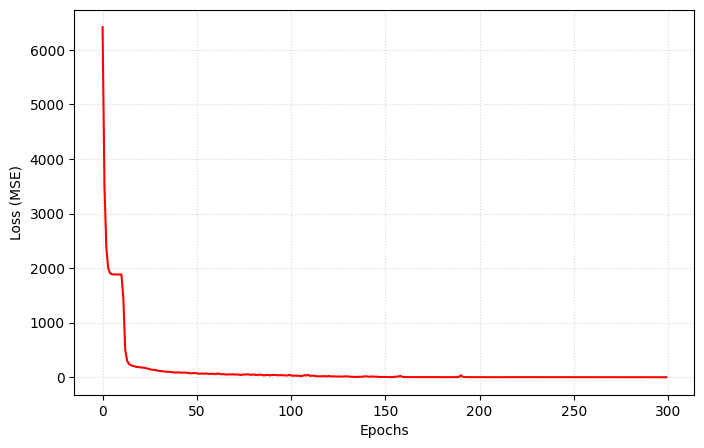

In [12]:
def plot_learning_curve(history: list[dict]):
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(
        range(len(history)), 
        history,
        color='red'
    )
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss (MSE)')
    ax.grid(axis='both', alpha=0.5, ls=':')
    plt.show()
plot_learning_curve(history)

In [13]:
checkpoint = {
    'model_state_dict': model.state_dict(),
    'input_dim': model.input_dim,
    'hidden_dim': model.hidden_dim,
    'num_layers': model.num_layers,
    'dropout_prob': model.dropout_prob, 
    'device': device,
    'normalization_stats': {
        'mean': mean,  
        'std': std     
    }
}d

save_dir = Path("../checkpoints")   
save_dir.mkdir(parents=True, exist_ok=True)

checkpoint_path = save_dir / "lstm_model_inference.pth"

torch.save(checkpoint, checkpoint_path)
print(f"Model saved at {checkpoint_path}")

Model saved at ..\checkpoints\lstm_model_inference.pth


# Test Prediction

Model loaded successfully from checkpoint for testing.
{'label': 'LSTMRegressor',
 'RMSE': np.float64(18.35592720285637),
 'R2': 0.8219768404960632}
None
Plotting performance for the first 50 test samples...


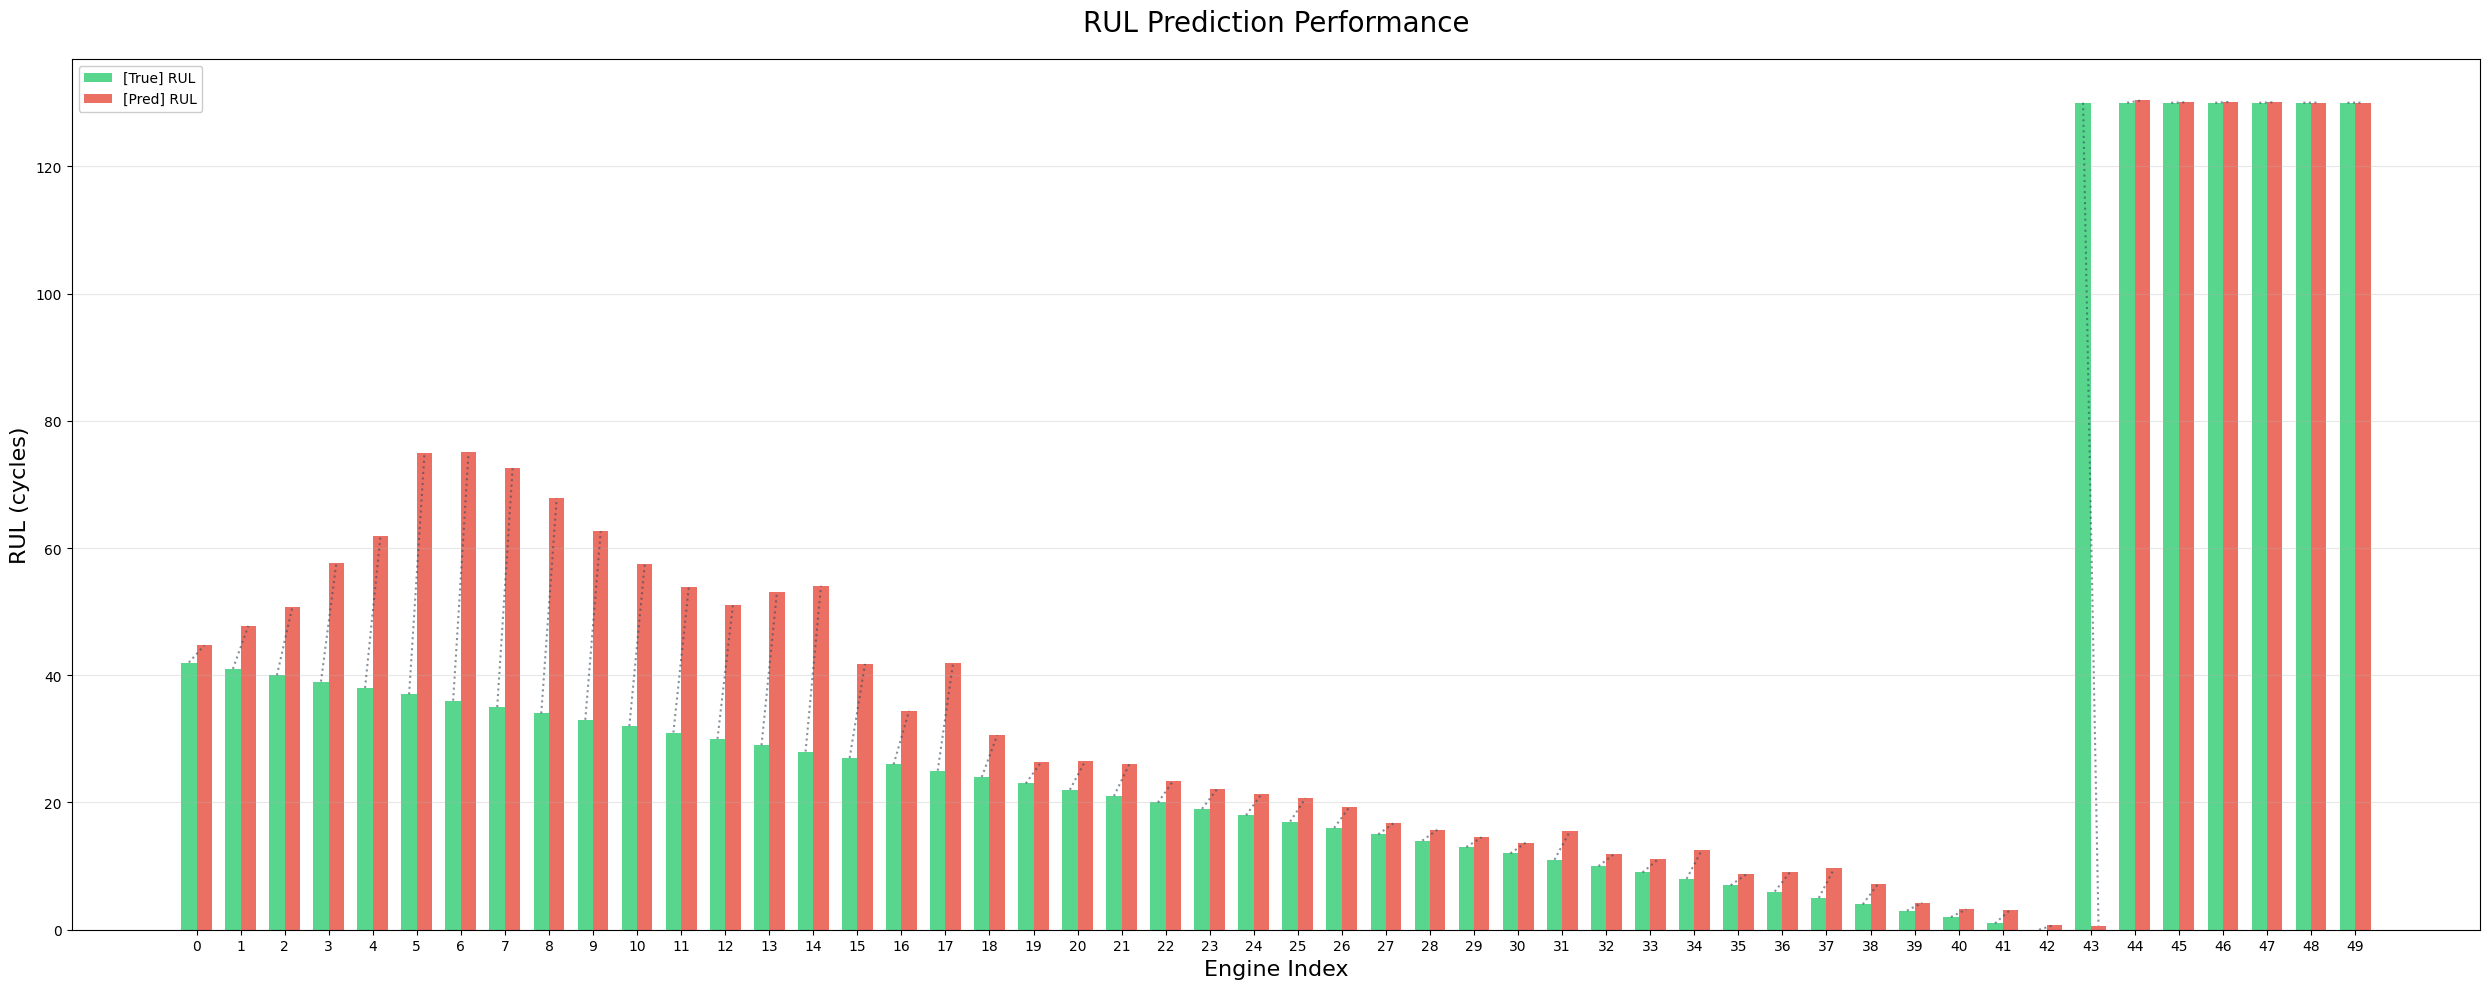

In [14]:
checkpoint = torch.load(checkpoint_path, weights_only=True)

# Instantiate the model using the saved hyperparameters
model_for_testing = LSTMRegressor(
    input_dim=checkpoint['input_dim'],
    hidden_dim=checkpoint['hidden_dim'],
    num_layers=checkpoint['num_layers'],
    dropout_prob=checkpoint.get('dropout_prob', 0.2) # .get for backward compatibility
).to('cpu')

# Load the trained weights
model_for_testing.load_state_dict(checkpoint['model_state_dict'])


# This turns off dropout and other training-specific layers.
model_for_testing.eval()

print("Model loaded successfully from checkpoint for testing.")

# The test set `X_test_seq` is already normalized, so we can use it directly.
# Use torch.no_grad() to make predictions more efficient (speed up inference)
with torch.no_grad():
    y_pred_tensor = model_for_testing(X_test_seq)

# Convert predictions and ground truth to NumPy arrays for plotting
# .cpu() is important if trained on GPU
y_pred_np = y_pred_tensor.cpu().numpy()
y_true_np = y_test_seq.cpu().numpy()


print(evaluate(y_true_np, y_pred_np, type(model).__name__))

SAMPLES_TO_PLOT = 50

print(f"Plotting performance for the first {SAMPLES_TO_PLOT} test samples...")

plot_performance(
    y_true=y_true_np, 
    y_pred=y_pred_np,
    max_engines=SAMPLES_TO_PLOT
)

## Final valid testing

In [15]:
SEQ_LEN = 30 # The same sequence length you used for training
df_test_rm = calculate_rolling_mean(df_test)
feature_columns_rm = feature_columns + [col for col in df_rm if col.endswith('rm')]

X_test_sequences = []
for engine_id in df_test_rm['engine'].unique():
    # Get the data for the current engine
    engine_data = df_test_rm[df_test_rm['engine'] == engine_id]
    
    # Extract the features for that engine
    engine_features = engine_data[feature_columns]
    last_sequence = engine_features.tail(SEQ_LEN).to_numpy()
    
    X_test_sequences.append(last_sequence)

X_test_final_np = np.array(X_test_sequences)

X_test_final = torch.tensor(X_test_final_np, dtype=torch.float32)

print(f"Shape of the final test sequences tensor: {X_test_final.shape}")

Shape of the final test sequences tensor: torch.Size([100, 30, 28])


{'label': 'LSTMRegressor',
 'RMSE': np.float64(18.931392276464788),
 'R2': 0.792458176612854}
Plotting performance on the final hold-out test set...


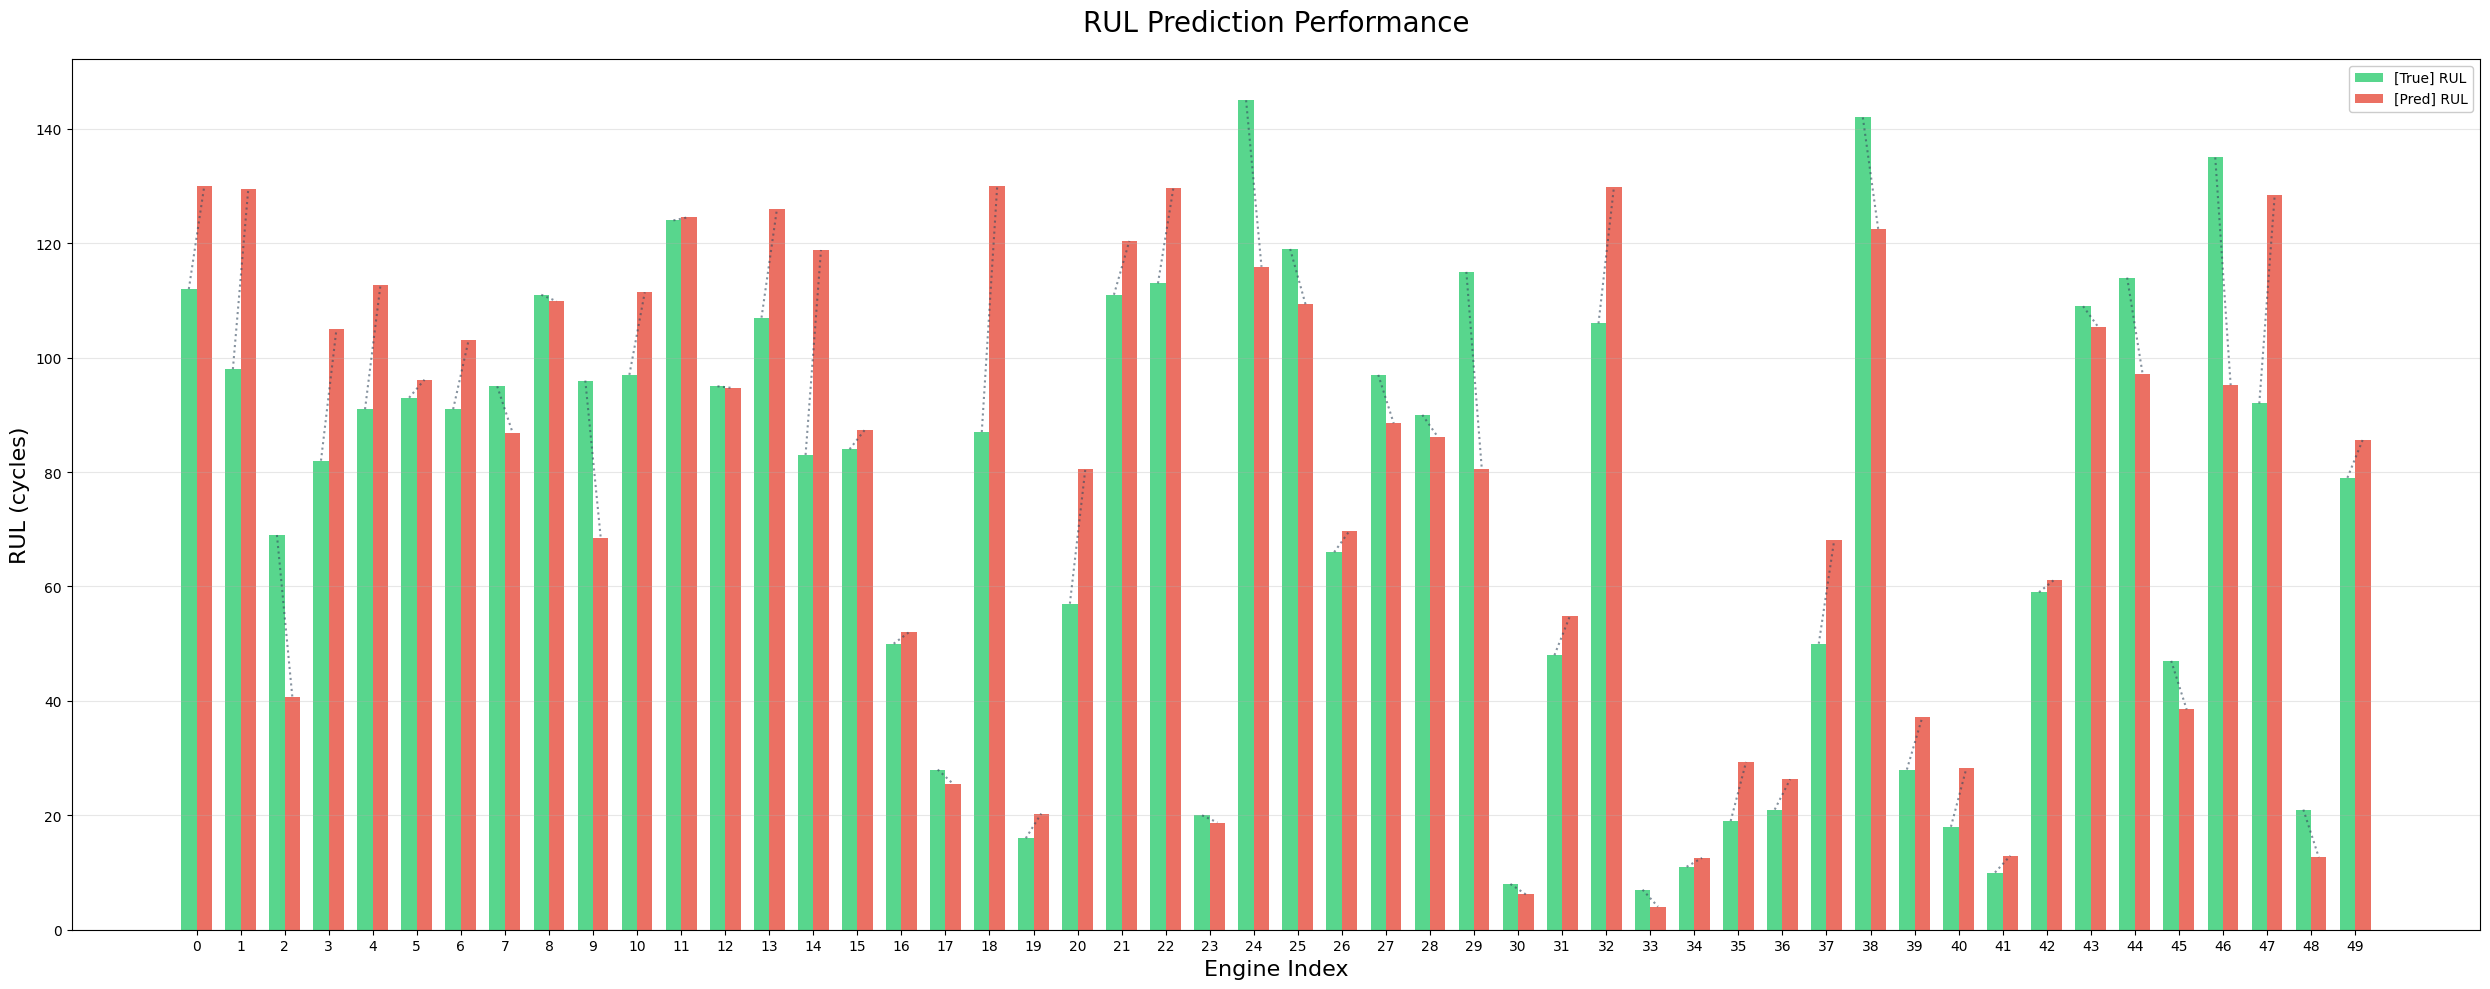

In [16]:
checkpoint = torch.load(checkpoint_path, weights_only=True)

mean = checkpoint['normalization_stats']['mean']
std = checkpoint['normalization_stats']['std']

# Apply the normalization
X_test_final_normalized = (X_test_final - mean) / std


# Make predictions on the final, prepared test set
with torch.no_grad():
    y_pred_final_tensor = model_for_testing(X_test_final_normalized)

# Convert predictions and ground truth to NumPy arrays
y_pred_final_np = y_pred_final_tensor.cpu().numpy()
y_true_final_np = y_valid.to_numpy() # y_valid is the RUL_FD001.txt data

evaluate(y_true_final_np, y_pred_final_np, type(model).__name__)

# Visualize the results using your plotting function
print("Plotting performance on the final hold-out test set...")
plot_performance(
    y_true=y_true_final_np, 
    y_pred=y_pred_final_np,
    max_engines=SAMPLES_TO_PLOT
)

A 80\% is a good benchmark performance for a regression task with this kind of dataset, is due to the origin of the data which is highly nonlinear, adding more feature information by manipulating the data from the sensors (like degradation lifespan) these features could help the model, but as for now these results seems okay.